In [2]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
from scipy.signal import medfilt
import scipy.stats as stats
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as ocean
from matplotlib import cm
from matplotlib.gridspec import GridSpec as GS
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
comdir = '/swot/SUM02/takaya/SOCCOM/SIO'
ddir = '/swot/SUM03/Argo_BGC_backscatter_SO_merged'

In [4]:
siodir = '/swot/SUM02/takaya/SOCCOM/SIO'
pf = pd.read_csv(op.join(siodir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(siodir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])

# Primary Production

In [5]:
import warnings
warnings.filterwarnings(action='once')

aB = 6.4e-6
A0,A1,A2,A3,A4,A5, = (5.80818,3.20684,4.11890,4.93845,1.01567,1.41575)
B0,B1,B2,B3 = -1e-3*np.array([7.01211,7.25958,7.93334,5.54491])
C0 = -1.32412e-7
pnew = np.append(np.arange(4,100,2),np.arange(100,510,10))
dp = np.diff(pnew)[:24]
dp = np.append(dp, 7)
dp = np.append(dp, np.diff(pnew[24:]))

v = 0
k,l,m,q,w = (0,0,0,0,0)
for floatid in range(2734,2744):
    istar = 1
    for i in range(istar,300):
        fname = op.join(ddir,'MR690%4d_%03d.nc' % (floatid,i))
        if op.exists(fname):
            ds = xr.open_dataset(fname)
            lat = np.nanmean(ds.LATITUDE)
            lon = np.nanmean(ds.LONGITUDE)
            p = ds.PRES.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PRES_QC,dtype=float),
                                                                         0.),3.),4.),6.),7.), 
                                          dims=ds.PRES_QC.dims, coords=ds.PRES_QC.coords)<9.)
            p = np.ma.masked_invalid(p.where(p!=99999.).where(p>0.))
            t = ds.TEMP.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.TEMP_QC,dtype=float),
                                                                        0.),3.),4.),6.),7.), 
                                          dims=ds.TEMP_QC.dims, coords=ds.TEMP_QC.coords)<9.)
            t = t.where(t!=99999.)
            s = ds.PSAL.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PSAL_QC,dtype=float),
                                                                        0.),3.),4.),6.),7.), 
                                          dims=ds.PSAL_QC.dims, coords=ds.PSAL_QC.coords)<9.)
            s = s.where(s!=99999.).where(s>0.)
            SA = xr.apply_ufunc(gsw.SA_from_SP,s,p,lon,lat)
            pt = xr.apply_ufunc(gsw.pt0_from_t,SA,t,p)
            CT = xr.apply_ufunc(gsw.CT_from_pt,SA,pt)
            rho = np.ma.masked_invalid(xr.apply_ufunc(gsw.rho,SA,CT,0)[0])
            pr = np.ma.masked_invalid(p[0])
            maskr = rho.mask
            maskpr = pr.mask
            if floatid == 2739 or floatid == 2738:
                par = ds.DOWNWELLING_PAR.where(xr.DataArray(maval(maval(maval(np.asarray(ds.DOWNWELLING_PAR_QC, 
                                                                                         dtype=float),
                                                                             4.),6.),7.), 
                                                           dims=ds.DOWNWELLING_PAR_QC.dims, 
                                                           coords=ds.DOWNWELLING_PAR_QC.coords)<9.)
                par = par.where(par!=99999.).where(par>0.)[-3]
                ppar = p[-3]
                pb = p[-2]
                bp700 = ds.BBP700.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.BBP700_QC,dtype=float),
                                                                                  0.),3.),4.),6.),7.), 
                                                    dims=ds.BBP700_QC.dims, coords=ds.BBP700_QC.coords)<9.
                                       ).where(ds.BBP700!=99999.)[-2]
                chl = ds.CHLA_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.CHLA_ADJUSTED_QC,
                                                                                                  dtype=float),
                                                                                        0.),3.),4.),6.),7.), 
                                                         dims=ds.CHLA_ADJUSTED_QC.dims, 
                                                         coords=ds.CHLA_ADJUSTED_QC.coords)<9.
                                            ).where(ds.CHLA_ADJUSTED!=99999.)[-2]
            else:
                par = ds.DOWNWELLING_PAR.where(xr.DataArray(maval(maval(maval(np.asarray(ds.DOWNWELLING_PAR_QC, 
                                                                                         dtype=float),
                                                                             4.),6.),7.), 
                                                            dims=ds.DOWNWELLING_PAR_QC.dims, 
                                                            coords=ds.DOWNWELLING_PAR_QC.coords)<9.)
                par = par.where(par!=99999.).where(par>0.)[-2]
                ppar = p[-2]

                ### BBP700 ###
                pb = p[-1]
                bp700 = ds.BBP700.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.BBP700_QC,dtype=float),
                                                                                   0.),3.),4.),6.),7.), 
                                                    dims=ds.BBP700_QC.dims, coords=ds.BBP700_QC.coords)<9.
                                       ).where(ds.BBP700!=99999.)[-1]
                chl = ds.CHLA_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.CHLA_ADJUSTED_QC,
                                                                                                   dtype=float),
                                                                                        0.),3.),4.),6.),7.), 
                                                         dims=ds.CHLA_ADJUSTED_QC.dims, 
                                                         coords=ds.CHLA_ADJUSTED_QC.coords)<9.
                                            ).where(ds.CHLA_ADJUSTED!=99999.)[-1]
            bp700 -= np.nanmedian(bp700.where(pb>=600))
            bp700 = np.ma.masked_invalid(medfilt(bp700.where(bp700>0.),5))
            chl -= np.nanmedian(chl.where(pb>=600))
            chl = np.ma.masked_invalid(medfilt(chl.where(chl>0.),5))
            par = np.ma.masked_invalid(medfilt(par.where(par>0.),5))
    
            maskpar = par.mask
            maskppar = ppar.mask
            maskc = chl.mask
            maskpb = pb.mask
            
            bp470 = bp700 * (470/700)**-.78
            Cphyto = 12128*bp470 + .59
            if ds.JULD[0].data.astype('datetime64')==np.datetime64('2017-07-21T06:43:00') or\
            ds.JULD[0].data.astype('datetime64')==np.datetime64('2018-01-01T06:39:00'):
                Cphyto[:] = np.nan
            maskb = Cphyto.mask

            if len(np.ma.masked_array(rho,maskpr).compressed())>1 and all(np.diff(np.ma.masked_array(pr,maskr).compressed())>0.):
                for u in range(len(ds.N_LEVELS)):
                    if ~np.isnan(rho[u]):
                        top = u
                        break
                if pr[top]<=2e1:
                    itop = np.abs(pr-10).argmin()
                    pML = pr[itop+np.nanargmin(np.abs((rho[itop:]-rho[itop])-0.03))]
                else:
                    pML = np.nan
                if m == 0:
                    pMLD = np.asarray([pML])
                    tnewr = np.asarray([ds.JULD[0].data.astype('datetime64')])
                    latr = np.asarray([lat])
                    lonr = np.asarray([lon])
                    nIDr = np.asarray([floatid])
                    m += 1
                else:
                    pMLD = np.append(pMLD, np.asarray([pML]))
                    tnewr = np.append(tnewr, ds.JULD[0].data.astype('datetime64'))
                    latr = np.append(latr, lat)
                    lonr = np.append(lonr, lon)
                    nIDr = np.append(nIDr, floatid)
            else:
                pML = np.nan
                    
            if len(np.ma.masked_array(Cphyto,maskpb).compressed())>1 and all(np.diff(np.ma.masked_array(pb,maskb).compressed())>0.)\
            and len(np.ma.masked_array(chl,maskpb).compressed())>1 and all(np.diff(np.ma.masked_array(pb,maskc).compressed())>0.):
                funC = pchip(np.ma.masked_array(pb,maskb).compressed(),
                             np.ma.masked_array(Cphyto,maskpb).compressed(),extrapolate=False)
                func = pchip(np.ma.masked_array(pb,maskc).compressed(),
                             np.ma.masked_array(chl,maskpb).compressed(),extrapolate=False)
                Ctp = funC(pnew).reshape((1,len(pnew)))
                Chltp = func(pnew).reshape((1,len(pnew)))
                dC = np.diff(Ctp,axis=-1)/np.diff(pnew)
                for i in range(Ctp.shape[0]):
                    pcrit = np.nanmax(np.array([1e2,pMLD[i]]))
                    for j in range(Ctp.shape[1]-1):
                        if pnew[j] > pcrit:
                            if dC[i,j] > 1.:
                                Ctp[i,j+1] = np.nan
                            elif dC[i,j] < -1.:
                                Ctp[i,j] = np.nan
                Ctp = np.ma.masked_invalid(Ctp)
                if l == 0:
                    C = Ctp
                    Chl = Chltp
                    tnewb = np.asarray([ds.JULD[0].data.astype('datetime64')])
                    latb = np.asarray([lat])
                    lonb = np.asarray([lon])
                    nIDb = np.asarray([floatid])
                    l += 1
                else:
                    C = np.append(C, Ctp, axis=0)
                    Chl = np.append(Chl, Chltp, axis=0)
                    tnewb = np.append(tnewb, ds.JULD[-1].data.astype('datetime64'))
                    latb = np.append(latb, lat)
                    lonb = np.append(lonb, lon)
                    nIDb = np.append(nIDb, floatid)

            if len(np.ma.masked_array(par,maskppar).compressed())>1 and all(np.diff(np.ma.masked_array(ppar,maskpar).compressed())>0.):
                func = pchip(np.ma.masked_array(ppar,maskpar).compressed(),
                             np.ma.masked_array(par,maskppar).compressed(),extrapolate=False)
                stkholder = np.ma.masked_less(par*1e-6*86400, 0.1)
                if len(stkholder.compressed())>0. and len(stkholder.compressed())<len(ppar):
                    pEu = ppar[len(stkholder.compressed())]
                else:
                    pEu = np.nan
                if q == 0:
                    Par = func(pnew).reshape((1,len(pnew)))
                    pEuD = np.asarray([pEu])
                    tnewp = np.asarray([ds.JULD[-2].data.astype('datetime64')])
                    latp = np.asarray([lat])
                    lonp = np.asarray([lon])
                    nIDp = np.asarray([floatid])
                    q += 1
                else:
                    Par = np.append(Par, func(pnew).reshape((1,len(pnew))), axis=0)
                    pEuD = np.append(pEuD, pEu)
                    tnewp = np.append(tnewp, ds.JULD[-2].data.astype('datetime64'))
                    latp = np.append(latp, lat)
                    lonp = np.append(lonp, lon)
                    nIDp = np.append(nIDp, floatid)
                    
            mlt = np.nanmean(pt.where(p<=pML)[0])
            PB = 1.3e-3 * 1.065**(mlt-20)
            #############################################
            # Phytoplankton division rate
            mu = chl/Cphyto * PB * (1.-np.exp(-aB*par/PB))
            #############################################
            if floatid == 2735:
                if ds.JULD[0].data.astype('datetime64')==np.datetime64('2017-07-21T06:43:00') or\
                ds.JULD[0].data.astype('datetime64')==np.datetime64('2018-01-01T06:39:00'):
                    mu[:] = np.nan
            pp = np.ma.masked_invalid(mu*Cphyto)
            maskpp = pp.mask
            mu = np.ma.masked_array(mu,maskpp)
            if len(np.ma.masked_array(pp,maskppar).compressed())>1 and all(np.diff(np.ma.masked_array(ppar,maskpp).compressed())>0.):
                funP = pchip(np.ma.masked_array(ppar,maskpp).compressed(),
                            np.ma.masked_array(pp,maskppar).compressed(),extrapolate=False)
                funM = pchip(np.ma.masked_array(ppar,maskpp).compressed(),
                            np.ma.masked_array(mu,maskppar).compressed(),extrapolate=False)
                PPtp = funP(pnew).reshape((1,len(pnew)))
                Mutp = funM(pnew).reshape((1,len(pnew)))
                if w == 0:
                    PP = PPtp
                    Mu = Mutp
                    tnewpp = np.asarray([ds.JULD[-2].data.astype('datetime64')])
                    latpp = np.asarray([lat])
                    lonpp = np.asarray([lon])
                    nIDpp = np.asarray([floatid])
                    w += 1
                else:
                    PP = np.append(PP, PPtp, axis=0)
                    Mu = np.append(Mu, Mutp, axis=0)
                    tnewpp = np.append(tnewpp, ds.JULD[-2].data.astype('datetime64'))
                    latpp = np.append(latpp, lat)
                    lonpp = np.append(lonpp, lon)
                    nIDpp = np.append(nIDpp, floatid)

Chlxr = xr.DataArray(Chl, dims=['time','pres'],
                    coords={'time':tnewb,'pres':pnew,'lat':('time',latb),'lon':('time',lonb),
                           'floatID':('time',nIDb)}
                    )
Cxr = xr.DataArray(C, dims=['time','pres'], 
                  coords={'time':tnewb,'pres':pnew,'lat':('time',latb),'lon':('time',lonb),
                         'floatID':('time',nIDb)}
                  )
Parxr = xr.DataArray(Par, dims=['time','pres'],
                    coords={'time':tnewp,'pres':pnew,'lat':('time',latp),'lon':('time',lonp),
                           'floatID':('time',nIDp)}
                    ).dropna('time',how='all')
pMLDxr = xr.DataArray(pMLD, dims=['time'], 
                     coords={'time':tnewr,'lat':('time',latr),'lon':('time',lonr),
                            'floatID':('time',nIDr)}
                     ).dropna('time',how='all')
pEuxr = xr.DataArray(pEuD, dims=['time'], 
                    coords={'time':tnewp,'lat':('time',latp),'lon':('time',lonp),
                           'floatID':('time',nIDp)}
                   ).dropna('time',how='all')
PPxr = xr.DataArray(PP, dims=['time','pres'],
                   coords={'time':tnewpp,'pres':pnew,'lat':('time',latpp),'lon':('time',lonpp),
                          'floatID':('time',nIDpp)}
                   ).dropna('time',how='all')
Muxr = xr.DataArray(Mu, dims=['time','pres'],
                   coords={'time':tnewpp,'pres':pnew,'lat':('time',latpp),'lon':('time',lonpp),
                          'floatID':('time',nIDpp)}
                   ).dropna('time',how='all')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in less_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:182: RuntimeWarning: Mean of empty slice
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/p

In [6]:
pnew = np.append(np.arange(4,100,2),np.arange(100,510,10))
dp = np.diff(pnew)[:24]
dp = np.append(dp, 7)
dp = np.append(dp, np.diff(pnew[24:]))

In [7]:
CChl_m = xr.DataArray(np.zeros((12,len(pnew))), dims=['month','pres'], 
                    coords={'month':range(1,13),'pres':pnew})
PP_m = xr.DataArray(np.zeros((12,len(pnew))), dims=['month','pres'], 
                   coords={'month':range(1,13),'pres':pnew})
Mu_m = xr.DataArray(np.zeros((12,len(pnew))), dims=['month','pres'], 
                   coords={'month':range(1,13),'pres':pnew})
pML_m = xr.DataArray(np.zeros(12), dims=['month'], 
                    coords={'month':range(1,13)})
pEu_m = xr.DataArray(np.zeros(12), dims=['month'], 
                    coords={'month':range(1,13)})
CChl = (Chlxr/Cxr).dropna('time',how='all')

for i in range(len(pnew)):
    CChl_m[:,i] = CChl[:,i].where(CChl[:,i]>0.).groupby('time.month').median().data
    PP_m[:,i] = PPxr[:,i].where(PPxr[:,i]>0.).groupby('time.month').median().data
    Mu_m[:,i] = Muxr[:,i].where(Muxr[:,i]>0.).groupby('time.month').median().data
    pML_m[:] = pMLDxr[:].groupby('time.month').mean().data
    pEu_m[:] = pEuxr[:].groupby('time.month').median().data

In [12]:
PAR_m = xr.DataArray(np.zeros((12,len(pnew))), dims=['month','pres'], 
                     coords={'month':range(1,13),'pres':pnew})
for i in range(len(pnew)):
    PAR_m[:,i] = Parxr[:,i].groupby('time.month').median().data

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


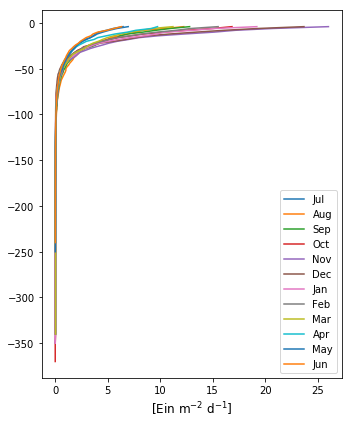

In [18]:
months = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
fig, ax = plt.subplots(figsize=(5,6))
fig.set_tight_layout(True)
for i in range(12):
    ax.plot(PAR_m.roll(month=6)[i]*1e-6*86400, -PAR_m.pres, label=months[i])
ax.set_xlabel(r"[Ein m$^{-2}$ d$^{-1}$]", fontsize=12)
ax.legend(loc='lower right')

In [19]:
grouped = (PPxr*dp).where(PPxr>0.).sum('pres').groupby('time.month')
PP_mz = grouped.median('time')

PP_mz25 = xr.DataArray(np.zeros(12), dims=['month'], 
                     coords={'month':range(1,13)})
PP_mz75 = xr.DataArray(np.zeros(12), dims=['month'], 
                     coords={'month':range(1,13)})
i = 0
for group in grouped:
    PP_mz25[i] = np.nanpercentile(group[1].data, 25)
    PP_mz75[i] = np.nanpercentile(group[1].data, 75)
    i += 1

In [20]:
stkholder = (PPxr*dp).where(PPxr>0.).sum('pres')
PP_yr = stkholder.median('time')
print(stkholder, PP_yr*365*86400)

<xarray.DataArray (time: 1138)>
array([0.005233, 0.005314, 0.007081, ..., 0.017592, 0.007675, 0.022275])
Coordinates:
  * time     (time) datetime64[ns] 2016-10-17T11:38:00 ... 2017-02-10T06:59:02
    lat      (time) float64 -48.77 -48.75 -48.75 -48.73 ... -59.4 -59.39 -59.4
    lon      (time) float64 72.3 72.3 72.31 72.33 ... 63.96 64.04 64.13 64.19
    floatID  (time) int64 2734 2734 2734 2734 2734 ... 2743 2743 2743 2743 2743 <xarray.DataArray ()>
array(164694.28005)


In [21]:
PP_yz25 = np.nanpercentile(stkholder.data, 25)
PP_yz75 = np.nanpercentile(stkholder.data, 75)

In [23]:
mu_z = np.nansum((Muxr*dp[np.newaxis,:]).where(Muxr.pres<=.5e2),axis=1)/.5e2
grouped = xr.DataArray(mu_z,dims=['time'],coords={'time':Muxr.time.data}).groupby('time.month')

Mu_mz25 = xr.DataArray(np.zeros(12), dims=['month'], 
                     coords={'month':range(1,13)})
Mu_mz75 = xr.DataArray(np.zeros(12), dims=['month'], 
                     coords={'month':range(1,13)})
i = 0
for group in grouped:
    Mu_mz25[i] = np.nanpercentile(group[1].data, 25)
    Mu_mz75[i] = np.nanpercentile(group[1].data, 75)
    i += 1

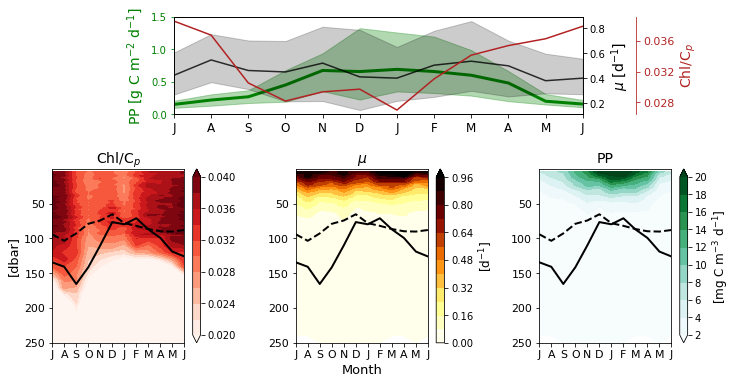

In [98]:
fig = plt.figure(figsize=(12,6))
gs = GS(5,6)
ax1 = fig.add_subplot(gs[:2,1:-1])
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("axes", 1.13))
ax2 = fig.add_subplot(gs[2:,:2])
ax3 = fig.add_subplot(gs[2:,2:4])
ax6 = fig.add_subplot(gs[2:,4:])
im5, = ax5.plot(range(12), np.roll(np.nansum((CChl_m*dp[np.newaxis,:]).where(CChl_m.pres<=.5e2),axis=1)/.5e2,6), 
                color='firebrick')
im1, = ax1.plot(range(12), PP_mz.roll(month=6)*86400*1e-3, 'g', lw=3)
ax1.fill_between(range(12), PP_mz25.roll(month=6)*86400*1e-3, PP_mz75.roll(month=6)*86400*1e-3,
                color='g', alpha=.3)
ax4.fill_between(range(12), Mu_mz25.roll(month=6)*86400, Mu_mz75.roll(month=6)*86400,
                color='k', alpha=.2)
im4, = ax4.plot(range(12), np.roll(np.nansum((Mu_m*dp[np.newaxis,:]).where(Mu_m.pres<=.5e2),axis=1)/.5e2*86400,6), 
                color='k', alpha=0.8)
im2 = ax2.contourf(range(12), -pnew, CChl_m.roll(month=6).T.data, levels=np.linspace(.02,.04,11),
                  cmap='Reds', extend='both')
im3 = ax3.contourf(range(12), -pnew, Mu_m.roll(month=6).T.data*86400, levels=np.arange(0,1.04,.08),
                  cmap='afmhot_r', extend='max')
ax2.plot(range(12), -np.roll(pML_m,6), c='k', lw=2)
ax2.plot(range(12), -np.roll(pEu_m,6), 'k--', lw=2)
ax3.plot(range(12), -np.roll(pML_m,6), c='k', lw=2)
ax3.plot(range(12), -np.roll(pEu_m,6), 'k--', lw=2)
im6 = ax6.contourf(range(12), -pnew, PP_m.roll(month=6).T.data*86400, levels=np.arange(2,22,2),
                  cmap='BuGn', extend='both')
ax6.plot(range(12), -np.roll(pML_m,6), c='k', lw=2)
ax6.plot(range(12), -np.roll(pEu_m,6), 'k--', lw=2)

ax1.yaxis.label.set_color(im1.get_color())
ax1.spines["left"].set_edgecolor(im1.get_color())
ax1.tick_params(axis='y', colors=im1.get_color())
ax4.yaxis.label.set_color(im4.get_color())
ax4.spines["right"].set_edgecolor(im4.get_color())
ax4.tick_params(axis='y', colors=im4.get_color())
ax5.yaxis.label.set_color(im5.get_color())
ax5.spines["right"].set_edgecolor(im5.get_color())
ax5.tick_params(axis='y', colors=im5.get_color())

ax1.set_xticks(range(12))
ax1.set_xlim([0,11])
ax1.set_ylim([0,1.5])
ax1.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=12)
ax3.set_xlabel(r"Month", fontsize=13)
ax5.set_ylabel(r"Chl/C$_p$", fontsize=14, color='firebrick')
ax1.set_ylabel(r"PP [g C m$^{-2}$ d$^{-1}$]", fontsize=14, color='g')
ax4.set_ylabel(r"$\mu$ [d$^{-1}$]", fontsize=14, color='k')

ax2.set_ylabel(r"[dbar]", fontsize=13)
ax2.set_xticks(range(12))
ax2.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=11)
ax2.set_ylim([-250,0])
ax2.set_yticks([-50,-100,-150,-200,-250])
ax2.set_yticklabels([50,100,150,200,250], fontsize=11)
ax3.set_xticks(range(12))
ax3.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=11)
ax3.set_ylim([-250,0])
ax3.set_yticks([-50,-100,-150,-200,-250])
ax3.set_yticklabels([50,100,150,200,250], fontsize=11)
ax6.set_xticks(range(12))
ax6.set_xticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],-6), fontsize=11)
ax6.set_ylim([-250,0])
ax6.set_yticks([-50,-100,-150,-200,-250])
ax6.set_yticklabels([50,100,150,200,250], fontsize=11)
ax5.set_yticks([.028,.032,.036])
ax5.set_yticklabels([.028,.032,.036], fontsize=11)
fig.subplots_adjust(right=0.88, hspace=2.5, wspace=1.8)

ax2.set_title(r"Chl/C$_p$", fontsize=14)
ax3.set_title(r"$\mu$", fontsize=14)
ax6.set_title(r"PP", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=[.02,.024,.028,.032,.036,.04])
cbar3 = fig.colorbar(im3, ax=ax3, ticks=[0,.16,.32,.48,.64,.8,.96])
cbar6 = fig.colorbar(im6, ax=ax6)
cbar3.set_label(r"[d$^{-1}$]", fontsize=12)
cbar6.set_label(r"[mg C m$^{-3}$ d$^{-1}$]", fontsize=12)